# House Price Prediction Model

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_log_error


In [3]:
# Initialize OneHotEncoder 
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## Load Data

In [4]:
data = pd.read_csv('../data/train.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
data.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [6]:
data.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

## Split Data into Training and Testing Sets

In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

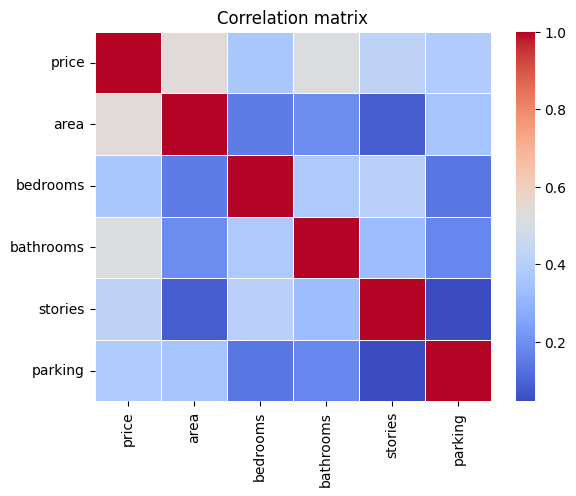

In [8]:
numeric_features = data.select_dtypes(include=[np.number])

corr = numeric_features.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix")
plt.show() 

## Define Features and Target Variable

In [9]:
# defining continous feautues
continuous_features = ['area', 'bedrooms']
# defining categorical feautues
categorical_features = ['mainroad', 'furnishingstatus']

# Target variable
target = 'price'

In [10]:
continuous_missing_values = data[continuous_features].isnull().sum()
print(continuous_missing_values)
categorical_missing_values = data[categorical_features].isnull().sum()
print(continuous_missing_values)

area        0
bedrooms    0
dtype: int64
area        0
bedrooms    0
dtype: int64


In [11]:

X_train = train_data[continuous_features + categorical_features]
X_test = test_data[continuous_features + categorical_features]
y_train = train_data[target]
y_test = test_data[target]


## Preprocessing Continuous Features
# Impute missing values using median and scale the features

In [12]:
# Preprocessing Continuous Features
imputer_cont = SimpleImputer(strategy='median')
scaler = StandardScaler()

In [13]:
# Fit the imputer on the training data
imputer_cont.fit(X_train[continuous_features])

# Transform the training data using the fitted imputer
X_train_cont_imputed = imputer_cont.transform(X_train[continuous_features])

# Fit the scaler on the imputed training data
scaler.fit(X_train_cont_imputed)

# Transform the imputed training data using the fitted scaler
X_train_cont = scaler.transform(X_train_cont_imputed)

In [14]:
X_test_cont = imputer_cont.transform(X_test[continuous_features])
X_test_cont = scaler.transform(X_test_cont)

## Preprocessing Categorical Features
# Impute missing values using most frequent value and one-hot encode the features

In [15]:
imputer_cat = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [16]:
# Fit the imputer on the categorical features
imputer_cat.fit(X_train[categorical_features])

# Transform the categorical features using the fitted imputer
X_train_cat_imputed = imputer_cat.transform(X_train[categorical_features])

# Fit the encoder on the imputed categorical features
encoder.fit(X_train_cat_imputed)

# Transform the imputed categorical features using the fitted encoder
X_train_cat = encoder.transform(X_train_cat_imputed)

In [17]:
X_test_cat = imputer_cat.transform(X_test[categorical_features])
X_test_cat = encoder.transform(X_test_cat)

X_train_cont shape: (436, 2)
X_test_cont shape: (109, 2)
X_train_cat shape: (436, 5)
X_test_cat shape: (109, 5)


## Combine Preprocessed Features

In [20]:
X_train_processed = np.hstack((X_train_cont, X_train_cat))
X_test_processed = np.hstack((X_test_cont, X_test_cat))

## Train Linear Regression Model

In [21]:
model = LinearRegression()
model.fit(X_train_processed, y_train)

LinearRegression()

## Predict on Test Set

In [22]:
y_pred = model.predict(X_test_processed)

## Calculate RMSLE

In [29]:
def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return round(rmsle, precision)

# Compute RMSLE using the provided function
rmsle = compute_rmsle(y_test, y_pred)
print(f'RMSLE: {rmsle}')

RMSLE: 0.33


In [36]:
joblib.dump(model, '../models/model.joblib')

['../models/model.joblib']

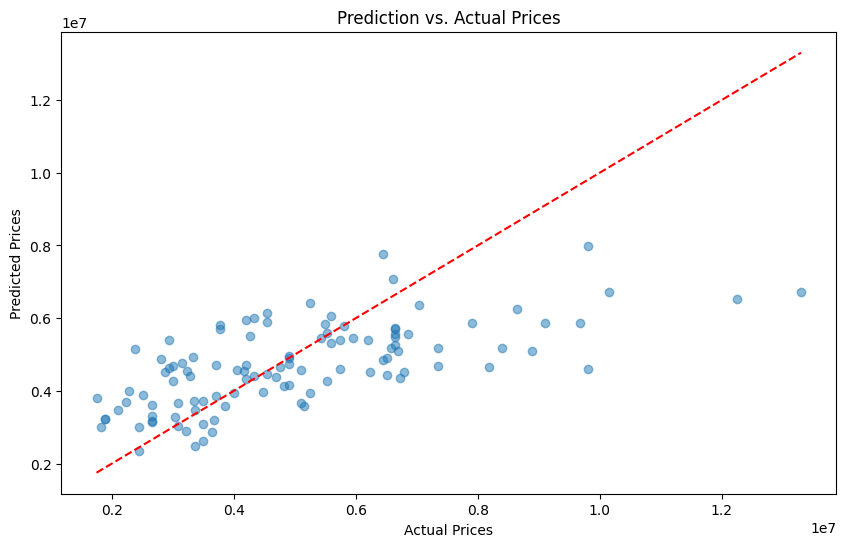

In [25]:

# Plot Prediction vs. Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Prediction vs. Actual Prices')
plt.show()


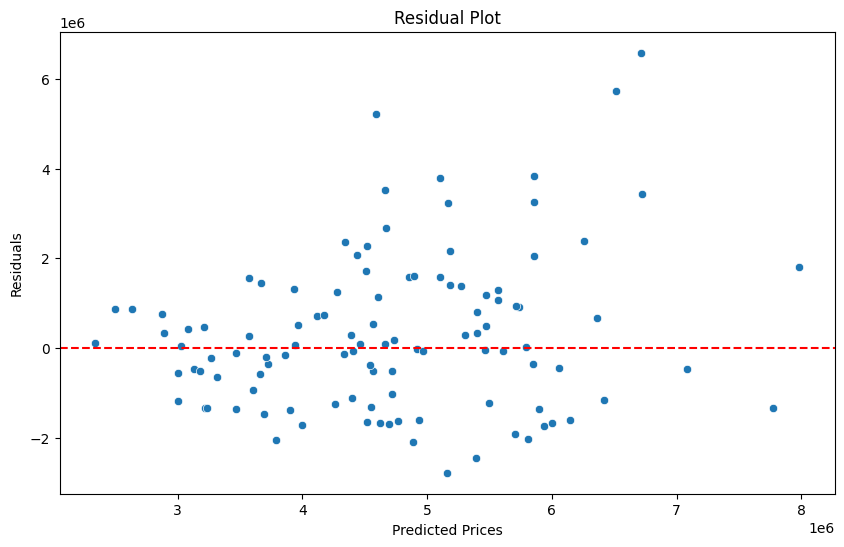

In [26]:
# Plot Residuals vs. Predicted Values
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


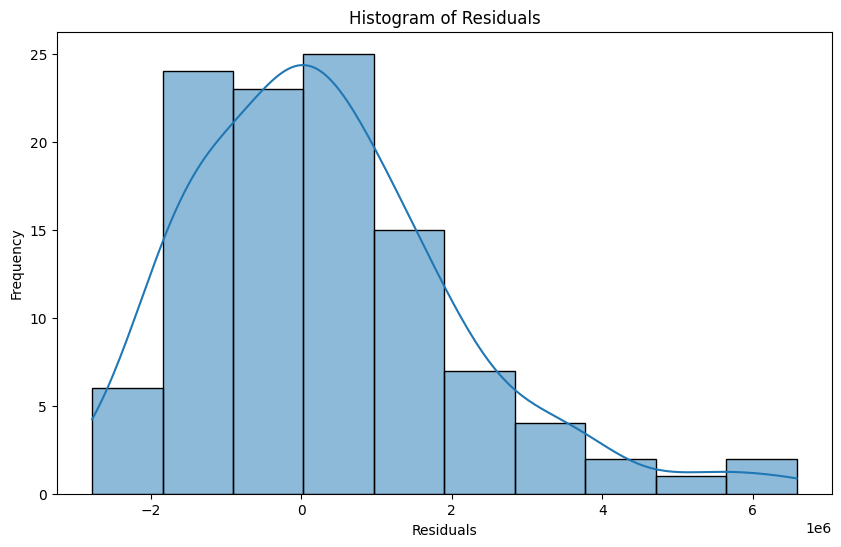

In [27]:
# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()